# ML2 Homework 2
LT5A: Castillo, Madarang

## Model Training

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.metrics import sensitivity_score, geometric_mean_score

# pipeline
from imblearn.pipeline import Pipeline

import concurrent.futures

In [3]:
import os

df = pd.read_csv(os.path.join("../../../data", 'ml2_student_performance.csv'))
df.head(5)

X, y = df.drop("Pass/Fail (1=Pass, 0=Fail)", axis=1), df["Pass/Fail (1=Pass, 0=Fail)"]

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.2,
                                                                  stratify=y)

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.25,
                                                                  stratify=y)

In [4]:
random_state = 42

param_grid = {
    "models": {
        "KNeighborsClassifier": KNeighborsClassifier(),
        # "LogisticRegressor": LogisticRegression(),
        # "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
        # "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_state),
        # "GradientBoostingClassifier": GradientBoostingClassifier(random_state=random_state)
    },
    "samplers": {
        # "ADASYN": ADASYN(random_state=random_state),
        "Random Oversampling": RandomOverSampler(random_state=random_state),
        # "Random Undersampling": RandomUnderSampler(random_state=random_state),
        # "SMOTE": SMOTE(random_state=random_state),
        # "Tomek Links": TomekLinks(),
        # "SMOTE-Tomek": SMOTETomek(random_state=random_state)
    }
}

In [18]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.svm import SVC

In [26]:
random_state = 42

param_grid = {
    "models": {
        "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_state),
        "SupportVectorClassifier": SVC(random_state=random_state),
    },
    "samplers": {
        "ADASYN": ADASYN(random_state=random_state),
        "Random Oversampling": RandomOverSampler(random_state=random_state),
        "Random Undersampling": RandomUnderSampler(random_state=random_state),
        "SMOTE": SMOTE(random_state=random_state),
        "Tomek Links": TomekLinks(),
        "SMOTE-Tomek": SMOTETomek(random_state=random_state),
    }
}

In [33]:
skf = StratifiedKFold(n_splits=5)


results_dict = {}
for model_name, model in param_grid["models"].items():

    for sampler_name, sampler in param_grid["samplers"].items():
        print(sampler_name)
        start = time.time()

        precision_scores = []
        recall_scores = []
        accuracy_scores = []
        gmean_scores = []

        for train_index, val_index in skf.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
            
            model.fit(X_resampled, y_resampled)

            y_scores = model.predict(X_val)
            precision_scores.append(precision_score(y_val, y_scores))
            recall_scores.append(recall_score(y_val, y_scores))
            accuracy_scores.append(accuracy_score(y_val, y_scores))
            gmean_scores.append(geometric_mean_score(y_val, y_scores))

        
        end_time = time.time() - start

        sampler_dict = {
            sampler_name: {
                "precision": np.mean(precision_scores),
                "recall": np.mean(recall_scores),
                "accuracy": np.mean(accuracy_scores),
                "gmean": np.mean(gmean_scores),
                "runtime": end_time
            }
        }

        print(sampler_dict)
    results_dict[model_name ] = sampler_dict

ADASYN
{'ADASYN': {'precision': np.float64(0.9521978295569845), 'recall': np.float64(0.9495124593716142), 'accuracy': np.float64(0.9066666666666666), 'gmean': np.float64(0.21106701022518265), 'runtime': 0.842883825302124}}
Random Oversampling
{'Random Oversampling': {'precision': np.float64(0.9525188453759883), 'recall': np.float64(0.9845759873928888), 'accuracy': np.float64(0.9386666666666666), 'gmean': np.float64(0.14527336134433105), 'runtime': 0.5730781555175781}}
Random Undersampling
{'Random Undersampling': {'precision': np.float64(0.9801870748299321), 'recall': np.float64(0.6144686299615878), 'accuracy': np.float64(0.6213333333333333), 'gmean': np.float64(0.672897570951241), 'runtime': 0.3814210891723633}}
SMOTE
{'SMOTE': {'precision': np.float64(0.9560040477214196), 'recall': np.float64(0.9439082044715847), 'accuracy': np.float64(0.9053333333333333), 'gmean': np.float64(0.3879020602533737), 'runtime': 0.7565250396728516}}
Tomek Links
{'Tomek Links': {'precision': np.float64(0.9

In [31]:
df_results = pd.DataFrame.from_dict(results_dict, orient="index")
df_results = df_results.stack().apply(pd.Series)

df_results.index.names = ['Model', 'Sampler']
df_results

,,precision,recall,accuracy,gmean,runtime
Model,Sampler,,,,,
RandomForestClassifier,SMOTE-Tomek,0.955992,0.943898,0.905333,0.387916,0.820439
DecisionTreeClassifier,SMOTE-Tomek,0.957921,0.893391,0.861333,0.457543,0.064850
SupportVectorClassifier,SMOTE-Tomek,0.972164,0.555511,0.561333,0.595177,0.213606


In [32]:
precision, recall, _ = precision_recall_curve(y_val, y_scores)

np.mean(precision)

np.float64(0.9777177177177178)

In [11]:
def evaluate_kfold_resampling(X_train, y_train, X_test, y_test, sampler, model):
    sampler = clone(sampler)
    model = clone(model)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    model.fit(X_resampled, y_resampled)
    y_scores = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auprc = auc(recall, precision)
    rec = sensitivity_score(y_test, y_scores)
    gmean = geometric_mean_score(y_test, y_scores)
    return auprc, rec, gmean, precision, recall

In [12]:
def evaluate_fold(model_name, sampler_name, model, sampler, X_trainval, y_trainval, train_index, val_index):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    auprc, rec, gmean, precision, recall = evaluate_kfold_resampling(
        X_train, y_train, X_val, y_val, sampler, model)
    return model_name, sampler_name, auprc, rec, gmean, precision, recall

In [13]:
skf = StratifiedKFold(n_splits=5)

results_dict = {}
start_time = time.time()
for model_name, model in param_grid["models"].items():
    for sampler_name, sampler in param_grid["samplers"].items():
        for train_index, val_index in skf.split(X_trainval, y_trainval):
            model_name, sampler_name, auprc, rec, gmean, precision, recall = evaluate_fold(
                model_name,
                sampler_name,
                model,
                sampler,
                X_trainval,
                y_trainval,
                train_index,
                val_index
            )


            if model_name not in results_dict:
                results_dict[model_name] = {}
            if sampler_name not in results_dict[model_name]:
                results_dict[model_name][sampler_name] = {
                    "auprc": [],
                    "rec": [],
                    "gmean": [],
                    "precision": [],
                    "recall": []
                }

            results_dict[model_name][sampler_name]["auprc"].append(auprc)
            results_dict[model_name][sampler_name]["rec"].append(rec)
            results_dict[model_name][sampler_name]["gmean"].append(gmean)
            results_dict[model_name][sampler_name]["precision"].append(precision)
            results_dict[model_name][sampler_name]["recall"].append(recall)

for model_name in results_dict:
    for sampler_name in results_dict[model_name]:
        results_dict[model_name][sampler_name]["runtime"] = time.time() - start_time
        
        # Replace lists with their mean values.
        results_dict[model_name][sampler_name] = {
            "auprc": np.mean(results_dict[model_name][sampler_name]["auprc"]),
            "rec": np.mean(results_dict[model_name][sampler_name]["rec"]),
            "gmean": np.mean(results_dict[model_name][sampler_name]["gmean"]),
            "precision": np.mean(results_dict[model_name][sampler_name]["precision"]),
            "recall": np.mean(results_dict[model_name][sampler_name]["recall"]),
            "runtime": results_dict[model_name][sampler_name]["runtime"]
        }



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [39]:
results_dict

{'KNeighborsClassifier': {'Random Oversampling': {'auprc': np.float64(0.9553218520609825),
   'rec': np.float64(0.9464285714285715),
   'gmean': np.float64(0.9591866641545395),
   'precision': np.float64(0.7588226990400904),
   'recall': np.float64(0.6488095238095238),
   'runtime': 0.05010199546813965}}}

## Model Evaluation

In [48]:
y_trainval.value_counts()

Class
0    213236
1       369
Name: count, dtype: int64

In [9]:
import json

with open("final_results.json", "r") as file:
    data = json.load(file)

In [10]:
import pandas as pd

df = pd.DataFrame.from_dict(data, orient="index")
df = df.stack().apply(pd.Series)

df.index.names = ['Model', 'Sampler']

In [11]:
df

auprc       rec     gmean  \
Model                      Sampler                                              
KNeighborsClassifier       ADASYN                0.246626  0.479452  0.668901   
                           Random Oversampling   0.159583  0.178860  0.419709   
                           Random Undersampling  0.327074  0.650500  0.640751   
                           SMOTE                 0.244082  0.474010  0.665805   
                           Tomek Links           0.413042  0.024398  0.139133   
                           SMOTE-Tomek           0.244091  0.474010  0.665836   
LogisticRegressor          ADASYN                0.478425  0.886338  0.931603   
                           Random Oversampling   0.472856  0.902555  0.933039   
                           Random Undersampling  0.468927  0.902555  0.928662   
                           SMOTE                 0.479408  0.883636  0.930687   
                           Tomek Links           0.677932  0.666901  0.815313   
                           SMOTE-Tomek           0.483282  0.886375  0.932686   
RandomForestClassifier     ADASYN                0.837258  0.805035  0.896783   
                           Random Oversampling   0.855537  0.761718  0.872154   
                           Random Undersampling  0.470725  0.889041  0.928742   
                           SMOTE                 0.839526  0.805035  0.896737   
                           Tomek Links           0.855642  0.758978  0.870706   
                           SMOTE-Tomek           0.838152  0.805035  0.896735   
DecisionTreeClassifier     ADASYN                0.586869  0.761718  0.871489   
                           Random Oversampling   0.752099  0.729174  0.853438   
                           Random Undersampling  0.462408  0.910663  0.899422   
                           SMOTE                 0.603807  0.777971  0.880851   
                           Tomek Links           0.732145  0.742651  0.861217   
                           SMOTE-Tomek           0.609715  0.777934  0.881033   
GradientBoostingClassifier ADASYN                0.535226  0.856572  0.922568   
                           Random Oversampling   0.529326  0.864717  0.926598   
                           Random Undersampling  0.464767  0.894447  0.925046   
                           SMOTE                 0.535158  0.853795  0.921212   
                           Tomek Links           0.681671  0.547575  0.735107   
                           SMOTE-Tomek           0.539350  0.856535  0.922719   

                                                 precision    recall  \
Model                      Sampler                                     
KNeighborsClassifier       ADASYN                 0.338210  0.493151   
                           Random Oversampling    0.380205  0.392953   
                           Random Undersampling   0.334924  0.550167   
                           SMOTE                  0.338325  0.491337   
                           Tomek Links            0.600576  0.341466   
                           SMOTE-Tomek            0.338330  0.491337   
LogisticRegressor          ADASYN                 0.357347  0.628779   
                           Random Oversampling    0.348239  0.634185   
                           Random Undersampling   0.345619  0.634185   
                           SMOTE                  0.358902  0.627879   
                           Tomek Links            0.563371  0.555634   
                           SMOTE-Tomek            0.360573  0.628792   
RandomForestClassifier     ADASYN                 0.623624  0.601678   
                           Random Oversampling    0.650224  0.587239   
                           Random Undersampling   0.351315  0.629680   
                           SMOTE                  0.625136  0.601678   
                           Tomek Links            0.651206  0.586326   
                           SMOTE-Tomek            0.624220  0.601678   
DecisionTreeClassif

In [15]:
df.reset_index(inplace=True)

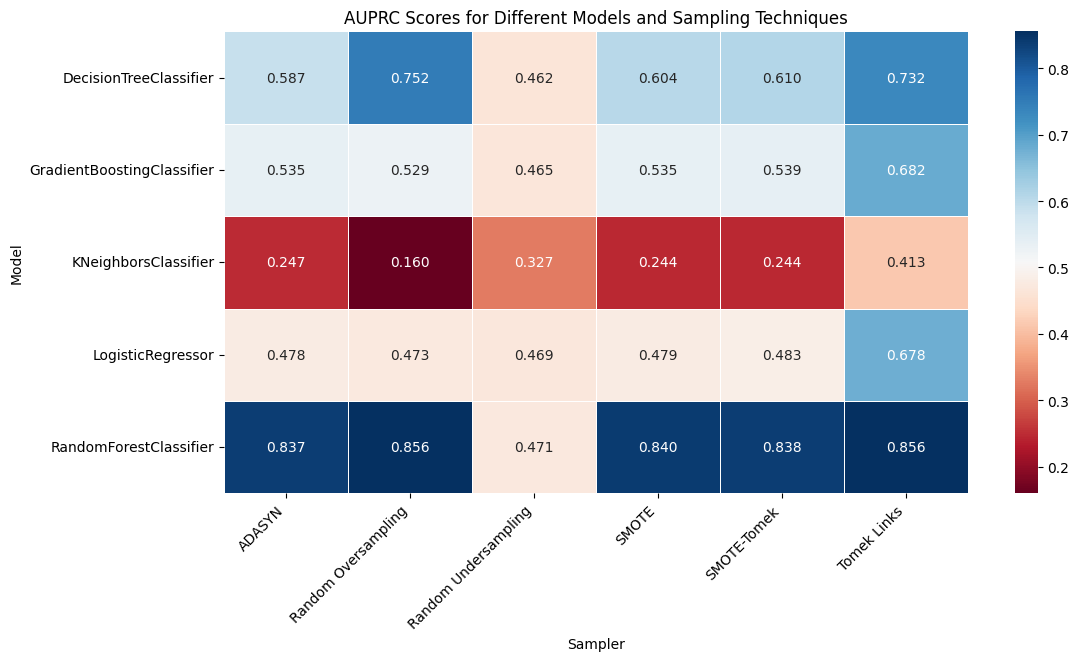

In [ ]:
plt.figure(figsize=(12, 6))

heatmap_data = df.pivot(index='Model', columns='Sampler', values='auprc')

sns.heatmap(heatmap_data, annot=True, cmap='RdBu', fmt=".3f", linewidths=0.5)

plt.title('AUPRC Scores for Different Models and Sampling Techniques')
plt.xlabel('Sampler')
plt.ylabel('Model')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## Key Insights

1. Overall, the best performing model-sampler combo is Random Forest with Random Oversampling and Tomek Links and the worst performing model-sampler combo is kNN. The fact that kNN performs badly is due to its algorithmic nature of distance-based classification and despite resampling techniques, no new pattern emerges that provides more information for the classifier.

2. Among the resampling techniques, Random Undersampling generally performed the worst while Random Oversampling consistently performed well. The only exception is the kNN Classifier and the assumption behind this is that kNN benefits from undersampling because it prevents majority class dominance, but oversampling simply duplicates the minority rate without introducing new patterns.

3. The ensemble methods don't have extremely large gains when using different resampling techniques, however it seems that for this dataset specifically implementing undersampling worsens the model significantly.

4. When comparing sampling techniques for single model, all of them improve when utilizing the Tomek Links resampling technique. This is likely due to how it removes the point belonging to a majority class that is close to a point belonging to a minority class thereby clarifying the decision boundary.

5. The performance of Random Forest Classifier among all resampling techniques being consistently high is likely due to the fact that its multiple trees are not easily misinformed by minor distortions in the data caused by duplicated or synthetic data.